# Analysing News Article Content with Google Cloud Natural Language API


## Imports and Setup


In [24]:
%load_ext autoreload
%autoreload 2

import requests
import time
import numpy as np
import pandas as pd

from utils import analyze_article, draw_boxplot_histogram
from pprint import pprint


from urllib.request import urlopen
from bs4 import BeautifulSoup
import feedparser

import concurrent.futures
import multiprocessing
from tqdm import tqdm

from ratelimit import limits, sleep_and_retry
from google.cloud import bigquery



num_processes = multiprocessing.cpu_count()


PROJECT = "aliz-ml-spec-2022-dev"
DATASET = "ml_specialization"
TABLE = "articles"




pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


# Table Creation

In [25]:
PROJECT = "aliz-ml-spec-2022-dev"
DATASET = "ml_specialization"
TABLE = "articles"

In [26]:
# Create dataset
bq_client = bigquery.Client()
bq_client.create_dataset(DATASET, exists_ok = True)
dataset_ref = bigquery.DatasetReference(PROJECT, DATASET)

# create date-partitioned table
SCHEMA = [
    bigquery.SchemaField("insert_datetime", "DATETIME", mode="NULLABLE", description="The timestamp in which this entry was inserted"),
    bigquery.SchemaField("publish_date", "DATE", mode="NULLABLE"),
    bigquery.SchemaField("title", "STRING", mode="NULLABLE"),
    bigquery.SchemaField("article_source_link", "STRING", mode="NULLABLE"),
    bigquery.SchemaField("article_sentiment", "FLOAT", mode="NULLABLE"),
    bigquery.SchemaField("persons", "RECORD", mode="REPEATED",
        fields=[
            bigquery.SchemaField("name", "STRING", mode="NULLABLE"),
            bigquery.SchemaField("wikipedia_uri", "STRING", mode="NULLABLE"),
            bigquery.SchemaField("num_sentences", "INT64", mode="NULLABLE"),
            bigquery.SchemaField("person_sentiment", "FLOAT", mode="NULLABLE"),
            ])]
DESCRIPTION = "This table stores the articles and their details, including the results from Natural Language API" 
                         
table_ref = dataset_ref.table(TABLE)
table = bigquery.Table(table_ref, schema=SCHEMA)
table.description=DESCRIPTION
table.time_partitioning = bigquery.TimePartitioning(
    type_=bigquery.TimePartitioningType.DAY,
    field="publish_date",  
) 
table = bq_client.create_table(table, exists_ok = True)  

print("Created table {}".format(table.full_table_id))

Created table aliz-ml-spec-2022-dev:ml_specialization.articles


# Dataset

You can either use a static csv dataset or an RSS feed.

Below dataset was obtained from [Harvard](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/GMFCTR)

In [27]:
article_df = pd.read_csv("NewsArticles.csv", encoding= 'unicode_escape')
article_df = article_df[["publish_date", "article_source_link", "title", "text"]]
article_df.dropna(axis =0 , subset = ["text"], inplace = True)
article_df.head(1)

,publish_date,article_source_link,title,text
0,2017/2/7,http://abcnews.go.com/Politics/pence-break-tie-betsy-devos-confirmation-vote-today/story?id=45310061,"Betsy DeVos Confirmed as Education Secretary, With Pence Casting Historic Tie-Breaking Vote","Michigan billionaire education activist Betsy DeVos was confirmed today to serve as the secretary of education in President Trump's administration, after Vice President Mike Pence cast a tie-breaking vote in the Senate. The Senate voted on DeVos""?highly contentious nomination this afternoon, and the tally was split evenly, requiring Pence to use his authority as president of the upper chamber of Congress to break the impasse. This was the first time that a vice president has broken a tie to confirm a Cabinet nominee. Pence read the vote count 50-50 and then voted himself, rendering the tally 51-50. The day before the vote, Democrats staged a 24-hour marathon of speeches, with more than 30 lawmakers taking to the floor to urge at least one additional Republican to vote against DeVos and block her confirmation. ""It is hard to imagine a worse choice,""?Sen. Elizabeth Warren, D-Mass., said before she read letters from constituents urging her to vote no. DeVos stirred up vehement opposition from teachers""?unions and all 48 Senate Democrats. Many cited concerns about her support of school vouchers, which critics believe will weaken public schools, and her lack of experience, since she never attended or worked in the public education system. Others cited her lack of familiarity with a landmark law protecting the education needs of disabled children. She was panned for a gaffe during her confirmation hearing, when she hedged on an answer about guns in schools by saying they might be needed in states like Wyoming to defend against ""potential grizzlies.""?DeVos' nomination drew above-average negative reactions from the public, with voters flooding Senate phone lines and email accounts in recent weeks. Sen. Chris Van Hollen, D-Md., said his office received 14,000 calls about DeVos. In addition to the entire Democratic caucus, two moderate Republicans, Sens. Susan Collins of Maine and Lisa Murkowski of Alaska announced they would not support DeVos. During a speech announcing her opposition, Collins said DeVos""?focus on charters and vouchers ""raises the question of whether or not she fully appreciates that the secretary of education's primary focus must be on helping states and communities, parents, teachers, school board members and administrators strengthen our public schools.""?Before the confirmation vote, the Senate Health, Education, Labor and Pensions Committee voted along party lines, 12-11, to refer DeVos""?nomination to the full Senate. ABC News""?Morgan Winsor contributed to this report."


# Analyse the Content Using Cloud Natural Language API

To use the Natural Language API we will import the required libraries.

# Example

In [28]:
NO = 40
sample_text = article_df["text"][NO]
sample_text_link = article_df['article_source_link'][NO]

In [31]:

print(f"sample_text (from {sample_text_link}):")
print("-"*100)
print(sample_text)

sample_text (from http://www.cnn.com/2017/02/07/sport/ski-world-championships-st-moritz-lindsey-vonn/index.html):
----------------------------------------------------------------------------------------------------
It's a chilling prospect and it's just the beginning of the men's downhill course in St. Moritz. The start hut is cut into a rock face and the slick slope is so steep -- 100% or 45 degrees -- TV cameramen must abseil into positions wearing crampons. But the one skier able to conquer their fear and harness this breakneck speed will be crowned world downhill champion for the next two years. The race is the highlight of the 2017 World Championships, which start this week in the chic Swiss town. St. Moritz, the jewel of the Engadin valley, has been a longtime destination for the jetset and draws a well-heeled international clientele to its fine-dining restaurants and five-star hotels.  Often dubbed the "home of winter sports," St. Moritz has hosted two Winter Olympics and four p

In [32]:
article_sentiment, persons = analyze_article(sample_text, postprocess=False)
print(f"Sentiment of this artice is {article_sentiment:.2f}")
print("Noteworthy individuals mentioned in the article are:")
pprint(persons[:4])

Sentiment of this artice is 0.10
Noteworthy individuals mentioned in the article are:
[{'name': 'Lindsey Vonn',
  'num_sentences': 2,
  'person_sentiment': 0.15000000596046448,
  'wikipedia_uri': 'https://de.wikipedia.org/wiki/Lindsey_Vonn'},
 {'name': 'Mikaela Shiffrin',
  'num_sentences': 1,
  'person_sentiment': 0.20000000298023224,
  'wikipedia_uri': 'https://de.wikipedia.org/wiki/Mikaela_Shiffrin'},
 {'name': 'Beat Feuz',
  'num_sentences': 1,
  'person_sentiment': 0.10000000149011612,
  'wikipedia_uri': 'https://de.wikipedia.org/wiki/Beat_Feuz'},
 {'name': 'Anna Veith',
  'num_sentences': 1,
  'person_sentiment': -0.30000001192092896,
  'wikipedia_uri': 'https://de.wikipedia.org/wiki/Anna_Veith'}]


# Application to all articles

In [ ]:
start = time.time()
    
# Process the rows in chunks in parallel
with concurrent.futures.ThreadPoolExecutor(num_processes) as pool:
    article_df['result'] = list(tqdm(pool.map(analyze_article, article_df['text'], chunksize=10), total=article_df.shape[0])) 
    
end = time.time()
print(end - start)

  6%|▌         | 225/3791 [00:19<01:17, 45.82it/s]/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 37%|███▋      | 1388/3791 [05:10<06:07,  6.54it/s]

In [ ]:
article_df['article_sentiment'], article_df['persons'] = article_df["result"].str

In [ ]:
article_df.to_csv("analyzed.csv")

# Analysis

In [113]:
article_df["article_len"] = article_df["text"].apply(len)
article_df["num_persons"] = article_df["persons"].apply(len)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


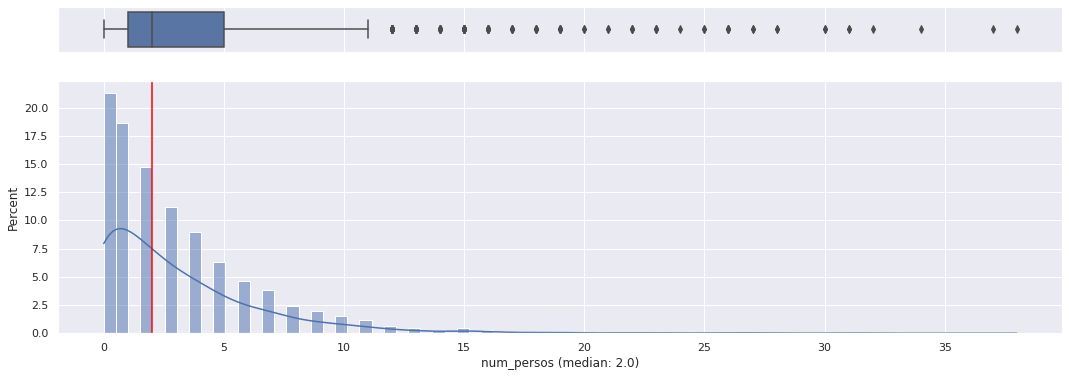

In [140]:
draw_boxplot_histogram(article_df, "num_persos")

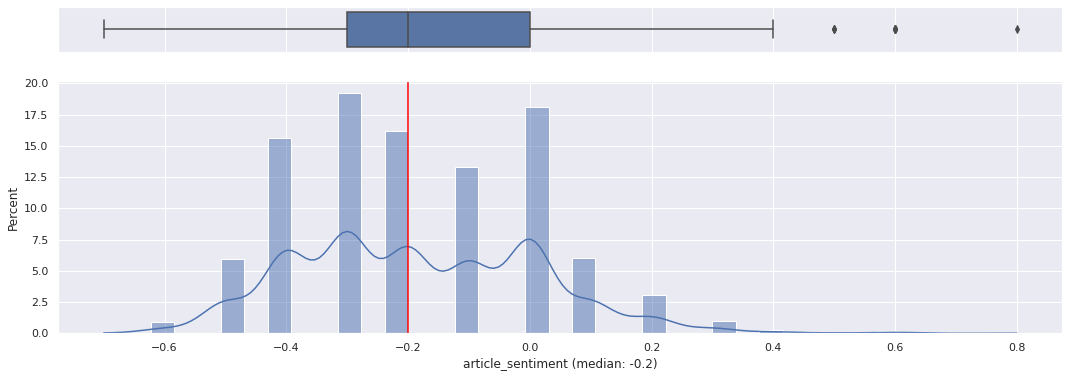

In [141]:
draw_boxplot_histogram(article_df, "article_sentiment")

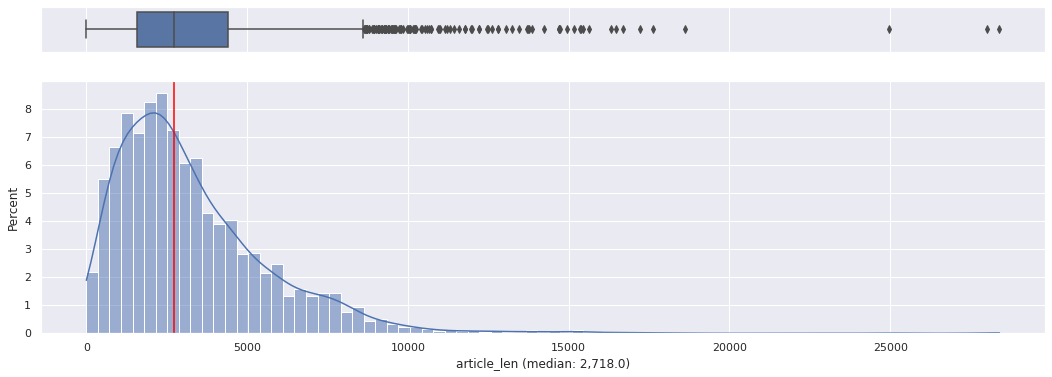

In [142]:
draw_boxplot_histogram(article_df, "article_len")

# Load to BQ

In [110]:
job_config = bigquery.LoadJobConfig(
    schema=SCHEMA,
    write_disposition="WRITE_TRUNCATE",
)

job = bq_client.load_table_from_dataframe(
    article_df, "aliz-ml-spec-2022-dev.ml_specialization.articles", job_config=job_config
)  # Make an API request.
job.result()  # Wait for the job to complete.


LoadJob<project=aliz-ml-spec-2022-dev, location=US, id=ec751b9a-ce02-4f35-9d18-e38e2093ab1a>

In [111]:
job.done()

True